### With PYMC
The BN is functional Bayesian network, which have the ability to generate continuous probability distribution for QoI (quantity of interest). However, for multiple buildings, the process is computationally heavu, therefore, we use discrete Bayesian network instead. The uncertainty quantification is less accurate, just an approximate. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pgmpy.base import DAG
from pgmpy.models import FunctionalBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.hybrid import FunctionalCPD
import pyro.distributions as dist
# from pgmpy.utils import get_example_model
from IPython.display import Image
from sklearn.metrics import mutual_info_score

import pymc as pm
import arviz as az

import time

from graphviz import Digraph
from IPython.display import Image

from scipy.stats import spearmanr

INFO:arviz:Found 'auto' as default backend, checking available backends
INFO:arviz:Matplotlib is available, defining as default backend
INFO:arviz.preview:arviz_base available, exposing its functions as part of arviz.preview
INFO:arviz.preview:arviz_stats available, exposing its functions as part of arviz.preview
INFO:arviz.preview:arviz_plots available, exposing its functions as part of arviz.preview


## The BN

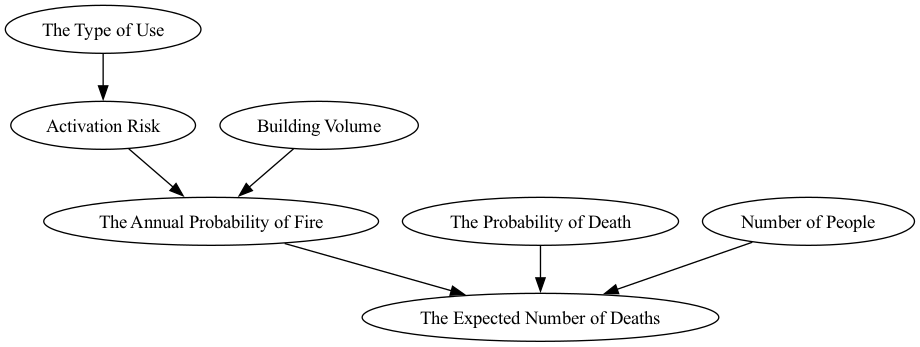

In [8]:
BN_risk = DAG()
BN_risk.add_nodes_from(nodes=['The Type of Use'])
BN_risk.add_edges_from(ebunch=[('The Type of Use', 'Activation Risk')])
BN_risk.add_edges_from(ebunch=[('Building Volume', 'The Annual Probability of Fire'),
                               ('Activation Risk', 'The Annual Probability of Fire')])
BN_risk.add_edges_from(ebunch=[('The Annual Probability of Fire', 'The Expected Number of Deaths'),
                               ('The Probability of Death', 'The Expected Number of Deaths'),
                               ('Number of People', 'The Expected Number of Deaths')])

# The expected numebr of deaths is just an risk indicator
viz = BN_risk.to_graphviz()
viz.draw('../../Output/Model_images/model_pm.png', prog='dot')
Image('../../Output/Model_images/model_pm.png')

# Aleatory uncertainty: irreducible uncertainty due to inherent randomness
# Activation risk, Building volume
# maybe the probability of death
# Epistemic uncertainty: reducible uncertainty due to lack of knowledge
# The probability of death - lack of knowledge, but what if it is beta distributed?
# Number of people - lack of knowledge, if known the distribution with more modern analysis
# Question: should I consider uncertainty in the causal nodes in the system? such as add a random noise on the annual probability of fire


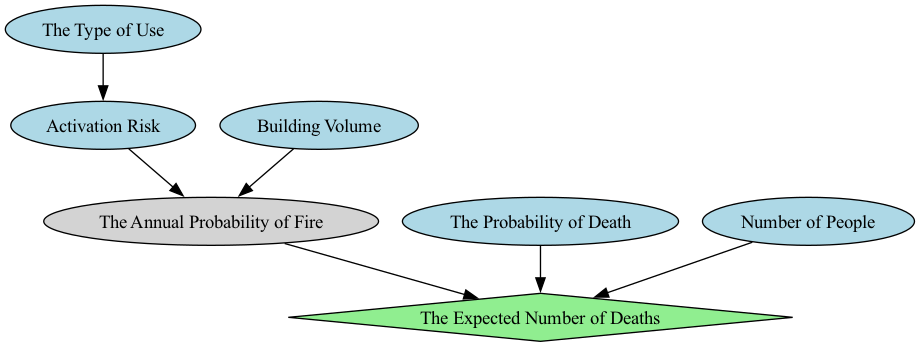

In [4]:
from graphviz import Digraph
from IPython.display import Image

# Define DAG
BN_risk = Digraph(format='png')
BN_risk.attr(rankdir='TB')  # top-to-bottom layout

# Add nodes
input_nodes = ['The Type of Use', 'Activation Risk', 'Building Volume',
               'The Probability of Death', 'Number of People']
intermediate_nodes = ['The Annual Probability of Fire']
output_nodes = ['The Expected Number of Deaths']

# Input nodes: blue ellipses
for node in input_nodes:
    BN_risk.node(node, style='filled', fillcolor='lightblue', shape='ellipse')

# Intermediate node: gray ellipse
for node in intermediate_nodes:
    BN_risk.node(node, style='filled', fillcolor='lightgray', shape='ellipse')

# Output node: green diamond
for node in output_nodes:
    BN_risk.node(node, style='filled', fillcolor='lightgreen', shape='diamond')

# Add edges
BN_risk.edges([('The Type of Use', 'Activation Risk')])
BN_risk.edges([
    ('Building Volume', 'The Annual Probability of Fire'),
    ('Activation Risk', 'The Annual Probability of Fire')
])
BN_risk.edges([
    ('The Annual Probability of Fire', 'The Expected Number of Deaths'),
    ('The Probability of Death', 'The Expected Number of Deaths'),
    ('Number of People', 'The Expected Number of Deaths')
])

# Render and display
BN_risk.render('../../Output/Model_images/model_pm', view=True)
Image('../../Output/Model_images/model_pm.png')

## The Fire risk model, generate synthetic data for experiment

In [7]:
#----------------------------
# Functions to calculate proabilities and risks
# Dictionaries for risk factors
#----------------------------


# Define Zweckcode categories (purpose codes for buildings)
activation_risk = [
    "Low Risk",
    "Middle Risk",
    "High Risk"
]

# Define risk factors dictionary
risk_factors = {
    "Low Risk": {
        "alpha": -9.011,
        "beta": 0.434,
        "gamma": 0.018
    },
    "Middle Risk": {
        "alpha": -9.005,
        "beta": 0.536,
        "gamma": 0.034
    },
    "High Risk": {
        "alpha": -9.422,
        "beta": 0.669,
        "gamma": 0.030
    }
}


In [8]:
# Define Zweckcode categories (purpose codes for buildings)
activation_risk = [
    "Low Risk",
    "Middle Risk",
    "High Risk"
]

# Define risk mapping dictionary
risk_level_map = {
    "Low Risk": 0,
    "Middle Risk": 1,
    "High Risk": 2
}

# Define reverse mapping for looking up risk factors
risk_level_reverse = {
    0: "Low Risk",
    1: "Middle Risk",
    2: "High Risk"
}

# Function to compute expected number of deaths
def compute_death_number(people, prob_fire, prob_death):
    return (people * prob_fire * prob_death)

risk_factors_array = {
    'alpha': np.array([-9.011, -9.005, -9.422]),
    'beta':  np.array([0.434, 0.536, 0.669]),
    'gamma': np.array([0.018, 0.034, 0.030])
}

def compute_prob_fire(volume, ar_level):
    """Vectorized version - handles arrays"""
    # Use ar_level as index
    alpha = risk_factors_array['alpha'][ar_level]
    beta = risk_factors_array['beta'][ar_level]
    gamma = risk_factors_array['gamma'][ar_level]
    result = 2/np.pi * np.arctan(1.0 * np.exp(alpha) * volume ** beta / np.exp(21 * gamma))
    return result  # Returns array

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of synthetic buildings
n_buildings = 20000

# Generate synthetic dataset
data = {
    "Building_ID": np.arange(1, n_buildings + 1),
    "activation_risk": np.random.choice(activation_risk, size=n_buildings),
    "Num_People": np.random.poisson(lam=45, size=n_buildings),  # avg 45 people per building
    "Volume_m3": np.random.normal(loc=2000, scale=100, size=n_buildings).clip(min=200),  # building volume
    "Probability_of_Death": np.random.beta(413.5, 176171.5, size=n_buildings)
}

# Risk indicator: Expected number of deaths
expected_deaths = []
for idx, people in enumerate(data["Num_People"]):
    if people == 0:
        expected_deaths.append(0)
    else:
        # The annual probability of fire
        ar_level = risk_level_map[data["activation_risk"][idx]]
        volume = data["Volume_m3"][idx]
        prob_fire = compute_prob_fire(volume, ar_level)

        # The probability of death given fire 
        prob_death = data["Probability_of_Death"][idx]
        
        # Expected deaths for this building
        death_expectation = compute_death_number(people, prob_fire, prob_death)
        expected_deaths.append(death_expectation)

        # Add some noise
        # deaths = np.random.poisson(lam=expected_deaths)
        # death_numbers.append(expected_deaths)
      
data["Expected_Deaths"] = expected_deaths

# Create DataFrame
df = pd.DataFrame(data)

print(df.head())
# The problem is the expected deaths is very low, e.g. 0.000366)

   Building_ID activation_risk  Num_People    Volume_m3  Probability_of_Death  \
0            1       High Risk          42  1935.123714              0.002413   
1            2        Low Risk          46  1929.597730              0.002288   
2            3       High Risk          48  2073.344945              0.002428   
3            4       High Risk          44  2070.983207              0.002553   
4            5        Low Risk          48  2162.450156              0.002447   

   Expected_Deaths  
0         0.000440  
1         0.000149  
2         0.000529  
3         0.000510  
4         0.000175  


In [20]:
# Extract infornmation for one building to run MCMC
building_idx = np.random.randint(0, n_buildings)
idx_people = data["Num_People"][building_idx] # Change this index to analyze different buildings
idx_ar = data["activation_risk"][building_idx]
idx_risk = risk_level_map[idx_ar]
idx_volume = data["Volume_m3"][building_idx]
idx_probability_of_death = data["Probability_of_Death"][building_idx]
idx_expected_deaths = data["Expected_Deaths"][building_idx]
idx_factors = risk_factors[idx_ar]
idx_alpha = idx_factors["alpha"]
idx_beta = idx_factors["beta"]
idx_gamma = idx_factors["gamma"]
print(f"Analyzing Building ID: {data['Building_ID'][building_idx]}, Risk: {idx_ar}, {idx_risk} "
      f"People: {idx_people}, Volume: {idx_volume:.1f} m³, \n"
      f"Probability of Death: {idx_probability_of_death}, \nExpected Deaths: {idx_expected_deaths:.6f}")


Analyzing Building ID: 4066, Risk: Low Risk, 0 People: 36, Volume: 2089.1 m³, 
Probability of Death: 0.002486986872747543, 
Expected Deaths: 0.000132


### Trial for the uncertainty quantification for one building

INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [prob_D]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
deaths,0.000,0.0,0.000,0.000,0.0,0.0,16037.0,25636.0,1.0
prob_D,0.002,0.0,0.002,0.003,0.0,0.0,16037.0,25636.0,1.0


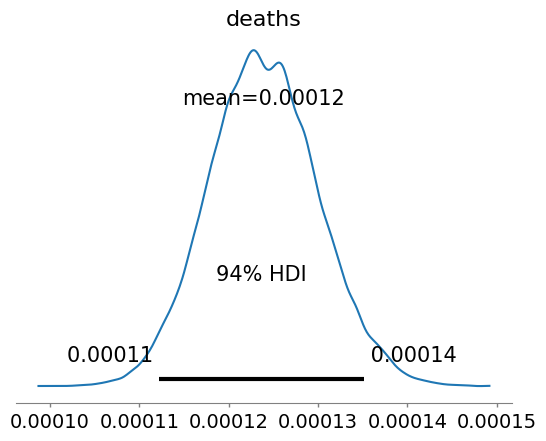

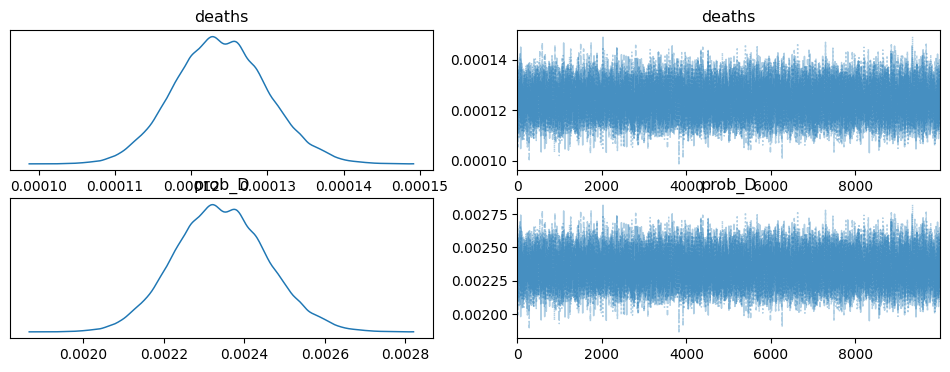

In [21]:
# Bayesian model using PyMC
with pm.Model() as model:
    people = idx_people
    prob_fire = compute_prob_fire(idx_volume, idx_risk)
    prob_D = pm.Beta("prob_D", alpha=413.5, beta=176171.5)
    deaths = pm.Deterministic("deaths", compute_death_number(people, prob_fire, prob_D))
    
    trace = pm.sample(10000)  # runs MCMC automatically

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True)
az.summary(trace, var_names=["deaths", "prob_D"])

### Trial with uncertainty on the inputs with one building

<!-- ar_level here is not a normal integer or integer NumPy array — it’s a PyMC random variable (pm.Categorical(...)), representing a symbolic random variable in the probabilistic model graph. -->

In [9]:
# The transition matrix for risk levels, put uncertainties in the risk level
M = np.array([
    [0.985, 0.01, 0.005],  # if risk=0: 85% stay, 10% ->1, 5% ->2
    [0.01, 0.980, 0.01],  # if risk=1: 10%->0, 80% stay 1, 10%->2
    [0.005, 0.010, 0.985],  # if risk=2: 5%->0, 10% ->1, 85% stay 2
])

In [19]:
volume_dist = pd.read_csv('../../Output/Data/volume_distribution.csv')
people_dist = pd.read_csv('../../Output/Data/occupants_distribution.csv')

In [16]:
import pytensor.tensor as pt

INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>CategoricalGibbsMetropolis: [people_idx, volume_idx, risk]
INFO:pymc.sampling.mcmc:>NUTS: [prob_D]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 0 tune and 11_000 draw iterations (0 + 44_000 draws total) took 3 seconds.
ERROR:pymc.stats.convergence:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


Elapsed time: 3.291496 seconds


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
deaths,0.000,0.000,0.000,0.000,0.000,0.000,10664.0,16549.0,1.0
people,12.913,7.993,4.350,24.450,0.081,0.072,9345.0,8377.0,1.0
people_idx,1.278,1.193,0.000,3.000,0.012,0.011,9345.0,8377.0,1.0
prob_D,0.002,0.000,0.002,0.003,0.000,0.000,19272.0,30737.0,1.0
risk,1.981,0.166,2.000,2.000,0.001,0.006,14936.0,44000.0,1.0
volume,4298.516,2356.116,920.095,9041.491,14.582,11.304,26392.0,25182.0,1.0
volume_idx,2.912,2.031,0.000,7.000,0.013,0.010,26392.0,25182.0,1.0


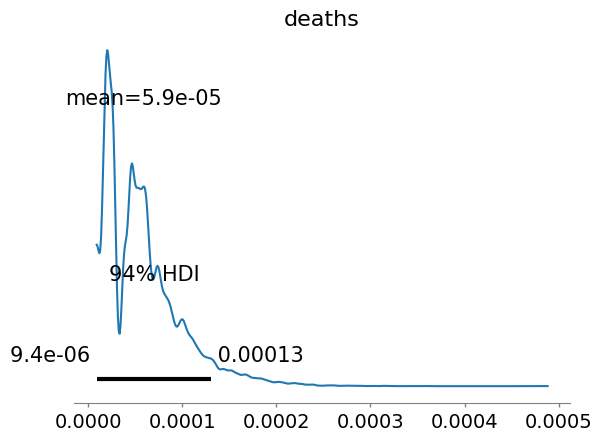

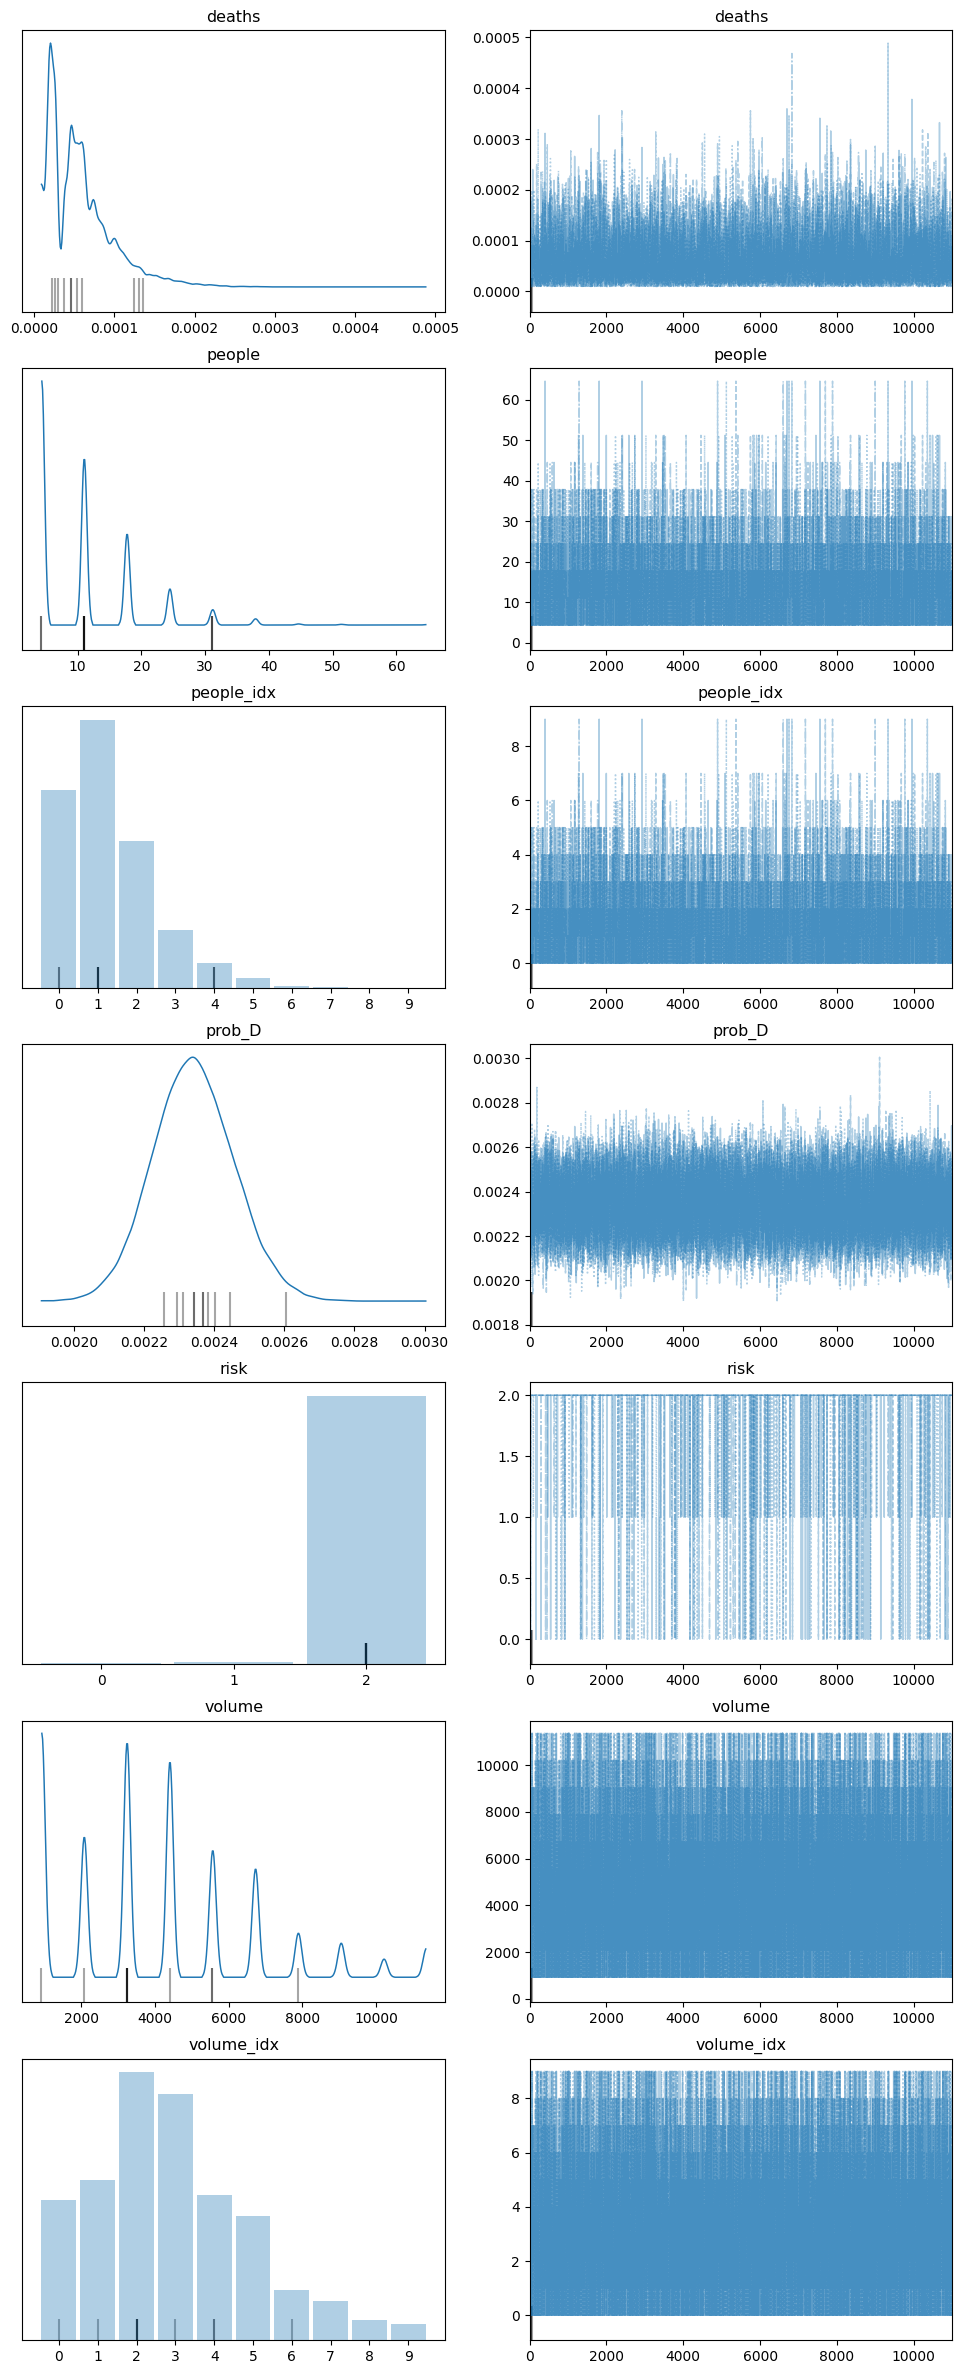

In [20]:
start = time.perf_counter()

with pm.Model() as model:
    # Add uncertainties to the key inputs
    # For number of people, a uniform distribution around the observed value
    # people = pm.Uniform("people", lower=max(0, idx_people - 5), upper=idx_people + 5)
    # Sample category index for number of people
    bin_midpoints_tensor = pt.as_tensor_variable(people_dist['bin_midpoint'].values)
    people_idx = pm.Categorical("people_idx", 
                               p=people_dist.loc[:, 'probability'].values)
    people = pm.Deterministic("people", bin_midpoints_tensor[people_idx]) 
 
    # For the probability of death, add uncertainties to the Beta distribution parameters (to show uncertainties on the model)
    # a_D = pm.Normal("a_D", mu=413.5, sigma=0.5) 
    # b_D = pm.Normal("b_D", mu=176171.5, sigma=50)
    # prob_D = pm.Beta("prob_D", alpha=a_D, beta=b_D)
    prob_D = pm.Beta("prob_D", alpha=413.5, beta=176171.5)
    
    # For Building volume, add a normal distribution around the observed value
    # volume = pm.math.maximum(
    #     pm.Normal("volume", mu=idx_volume, sigma=50),
    #     200.0
    # )
    volume_midpoints_tensor = pt.as_tensor_variable(volume_dist['bin_midpoint'].values)
    volume_idx = pm.Categorical("volume_idx", 
                               p=volume_dist.loc[:, 'probability'].values)
    volume = pm.Deterministic("volume", volume_midpoints_tensor[volume_idx])

    # For activation risk, use transition matrix row corresponding to uncertainty in activation risk
    p_true = M[2]
    risk = pm.Categorical("risk", p=p_true)  # sample true risk
    
    # Get risk factors directly using switch
    alpha = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["alpha"],  # risk = 0
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["alpha"],  # risk = 1
            risk_factors["High Risk"]["alpha"]     # risk = 2
        )
    )
    
    beta = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["beta"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["beta"],
            risk_factors["High Risk"]["beta"]
        )
    )
    
    gamma = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["gamma"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["gamma"],
            risk_factors["High Risk"]["gamma"]
        )
    )
    
    # Calculate fire probability using the selected risk factors
    prob_fire = 2/np.pi * pm.math.arctan(
        1.0 * pm.math.exp(alpha) * 
        volume ** beta / 
        pm.math.exp(21 * gamma)
    )

    deaths = pm.Deterministic("deaths", people*prob_fire*prob_D)
    
    trace = pm.sample(10000)  # runs MCMC automatically

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True, figsize=(12, 30))
az.summary(trace)

### Sensitivity analysis

#### Based on coorelation analysis

In [21]:
# Coorelation analysis
volume = trace.posterior["volume"].values.flatten()
risk_samples = trace.posterior["risk"].values.flatten()
people_samples = trace.posterior["people"].values.flatten()
prob_D_samples = trace.posterior["prob_D"].values.flatten()

deaths_samples = trace.posterior["deaths"].values.flatten()

corr_v, _ = spearmanr(deaths_samples, volume)
print("Sensitivity (deaths vs volume):", corr_v)
corr_r, _ = spearmanr(deaths_samples, risk_samples)
print("Sensitivity (deaths vs risk):", corr_r)
corr_p, _ = spearmanr(deaths_samples, people_samples)
print("Sensitivity (deaths vs people):", corr_p)
corr_D, _ = spearmanr(deaths_samples, prob_D_samples)
print("Sensitivity (deaths vs prob_D):", corr_D)


Sensitivity (deaths vs volume): 0.3948295855120109
Sensitivity (deaths vs risk): -0.026335622508935043
Sensitivity (deaths vs people): 0.9018313510466108
Sensitivity (deaths vs prob_D): 0.07038301621990094


#### Based on Mutual information analysis


Mutual Information Analysis:
MI(deaths, volume): 0.560783
MI(deaths, risk): 0.003216
MI(deaths, people): 0.874068
MI(deaths, prob_D): 0.057071


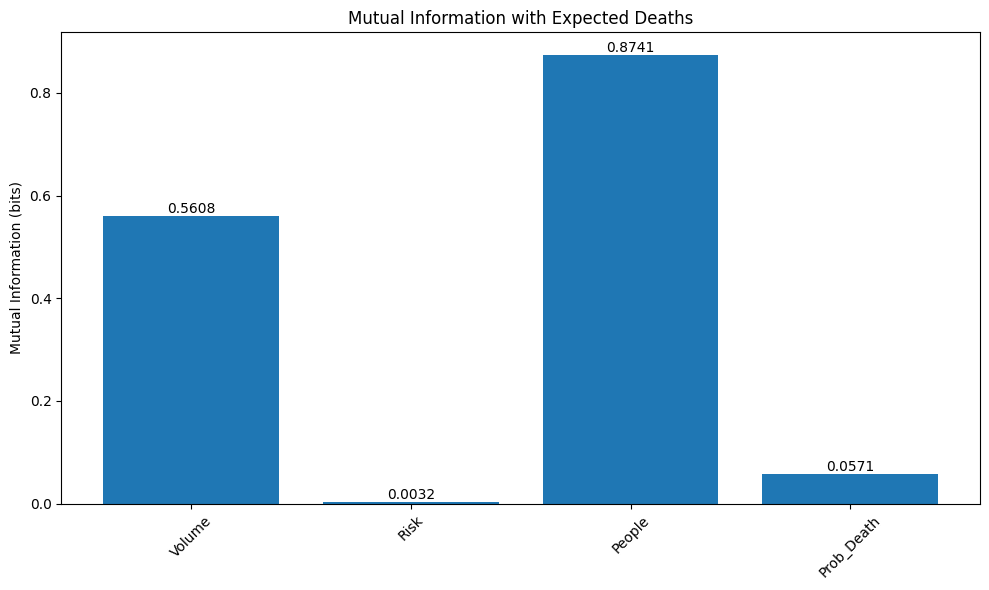

In [24]:
#-- Mutual Information Analysis ----

# Get samples from trace
volume = trace.posterior["volume"].values.flatten()
risk_samples = trace.posterior["risk"].values.flatten()
people_samples = trace.posterior["people"].values.flatten()
prob_D_samples = trace.posterior["prob_D"].values.flatten()
deaths_samples = trace.posterior["deaths"].values.flatten()
# a_D_sampels = trace.posterior["a_D"].values.flatten()
# b_D_sampels = trace.posterior["b_D"].values.flatten()

# Function to calculate MI for continuous variables
def calc_mi_continuous(x, y, bins=50):
    # Discretize continuous variables using bins
    x_bins = np.histogram_bin_edges(x, bins=bins)
    y_bins = np.histogram_bin_edges(y, bins=bins)
    
    x_discrete = np.digitize(x, x_bins)
    y_discrete = np.digitize(y, y_bins)
    
    return mutual_info_score(x_discrete, y_discrete)

# Calculate MI for each input variable
mi_volume = calc_mi_continuous(volume, deaths_samples)
mi_risk = mutual_info_score(risk_samples, np.digitize(deaths_samples, 
                          np.histogram_bin_edges(deaths_samples, bins=50)))
mi_people = calc_mi_continuous(people_samples, deaths_samples)
mi_prob_D = calc_mi_continuous(prob_D_samples, deaths_samples)
# mi_a_D = calc_mi_continuous(a_D_sampels, deaths_samples)
# mi_b_D = calc_mi_continuous(b_D_sampels, deaths_samples)

# Print results
print("\nMutual Information Analysis:")
print(f"MI(deaths, volume): {mi_volume:.6f}")
print(f"MI(deaths, risk): {mi_risk:.6f}")
print(f"MI(deaths, people): {mi_people:.6f}")
print(f"MI(deaths, prob_D): {mi_prob_D:.6f}")
# print(f"MI(deaths, a_D): {mi_a_D:.6f}")
# print(f"MI(deaths, b_D): {mi_b_D:.6f}")

# Plot MI values
plt.figure(figsize=(10, 6))
variables = ['Volume', 'Risk', 'People', 'Prob_Death']
mi_values = [mi_volume, mi_risk, mi_people, mi_prob_D]

bars = plt.bar(variables, mi_values)
plt.title('Mutual Information with Expected Deaths')
plt.ylabel('Mutual Information (bits)')
plt.xticks(rotation=45)
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Uncertainty Analysis

#### Credible interval analysis 95%

In [11]:
# Just be the credible interval analysis 2.5%-97.5%
ci_deaths = az.hdi(trace, var_names=["deaths"], hdi_prob=0.95)
print(f"95% Credible Interval for Expected Deaths: {ci_deaths['deaths'].values[0]*100}% ~ {ci_deaths['deaths'].values[1]*100}%")

95% Credible Interval for Expected Deaths: 0.015873621821729366% ~ 0.022989063783853843%


Entropy: Entropy provides a useful metric for comparing uncertainty across different models or datasets, and it is commonly used in information theory and decision theory.


Entropy Analysis:
Entropy of death distribution: 3.1768 bits


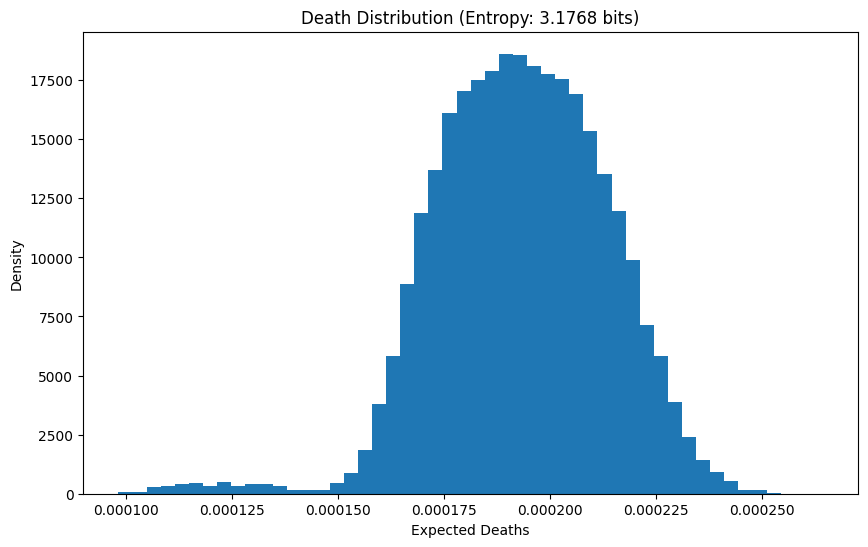

In [13]:
def calculate_entropy(samples, bins=50):
    hist, _ = np.histogram(samples, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zero entries to avoid log(0)
    hist = hist / np.sum(hist)  # Normalize histogram
    entropy = -np.sum(hist * np.log(hist))
    return entropy

deaths_samples = trace.posterior["deaths"].values.flatten()
deaths_entropy = calculate_entropy(deaths_samples, bins=50)
print(f"\nEntropy Analysis:")
print(f"Entropy of death distribution: {deaths_entropy:.4f} bits")

# Visualize distribution with entropy
plt.figure(figsize=(10, 6))
plt.hist(deaths_samples, bins=50, density=True)
plt.title(f'Death Distribution (Entropy: {deaths_entropy:.4f} bits)')
plt.xlabel('Expected Deaths')
plt.ylabel('Density')
plt.show()

#### Fix aleatory uncertainty 
step1: run this block\
step2: do sensitivity analysis above

INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:CompoundStep
INFO:pymc.sampling.mcmc:>NUTS: [people, a_D, b_D, prob_D, volume]
INFO:pymc.sampling.mcmc:>CategoricalGibbsMetropolis: [risk]


Output()

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 3 seconds.


Elapsed time: 4.583532 seconds


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E_prob_D,0.002,0.000,0.002,0.002,0.000,0.000,51457.0,33178.0,1.0
a_D,413.503,0.498,412.564,414.432,0.002,0.002,50561.0,32548.0,1.0
b_D,176171.575,50.055,176078.099,176265.744,0.198,0.243,63759.0,32987.0,1.0
deaths,0.000,0.000,0.000,0.000,0.000,0.000,50862.0,32381.0,1.0
people,42.013,1.728,39.142,44.779,0.007,0.006,46384.0,28639.0,1.0
prob_D,0.002,0.000,0.002,0.003,0.000,0.000,56273.0,33745.0,1.0
risk,1.980,0.172,2.000,2.000,0.001,0.006,14756.0,40000.0,1.0
volume,1982.707,49.953,1889.597,2077.656,0.196,0.250,65194.0,33397.0,1.0


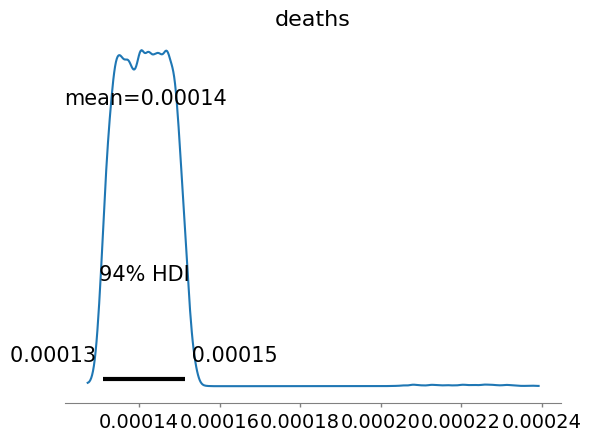

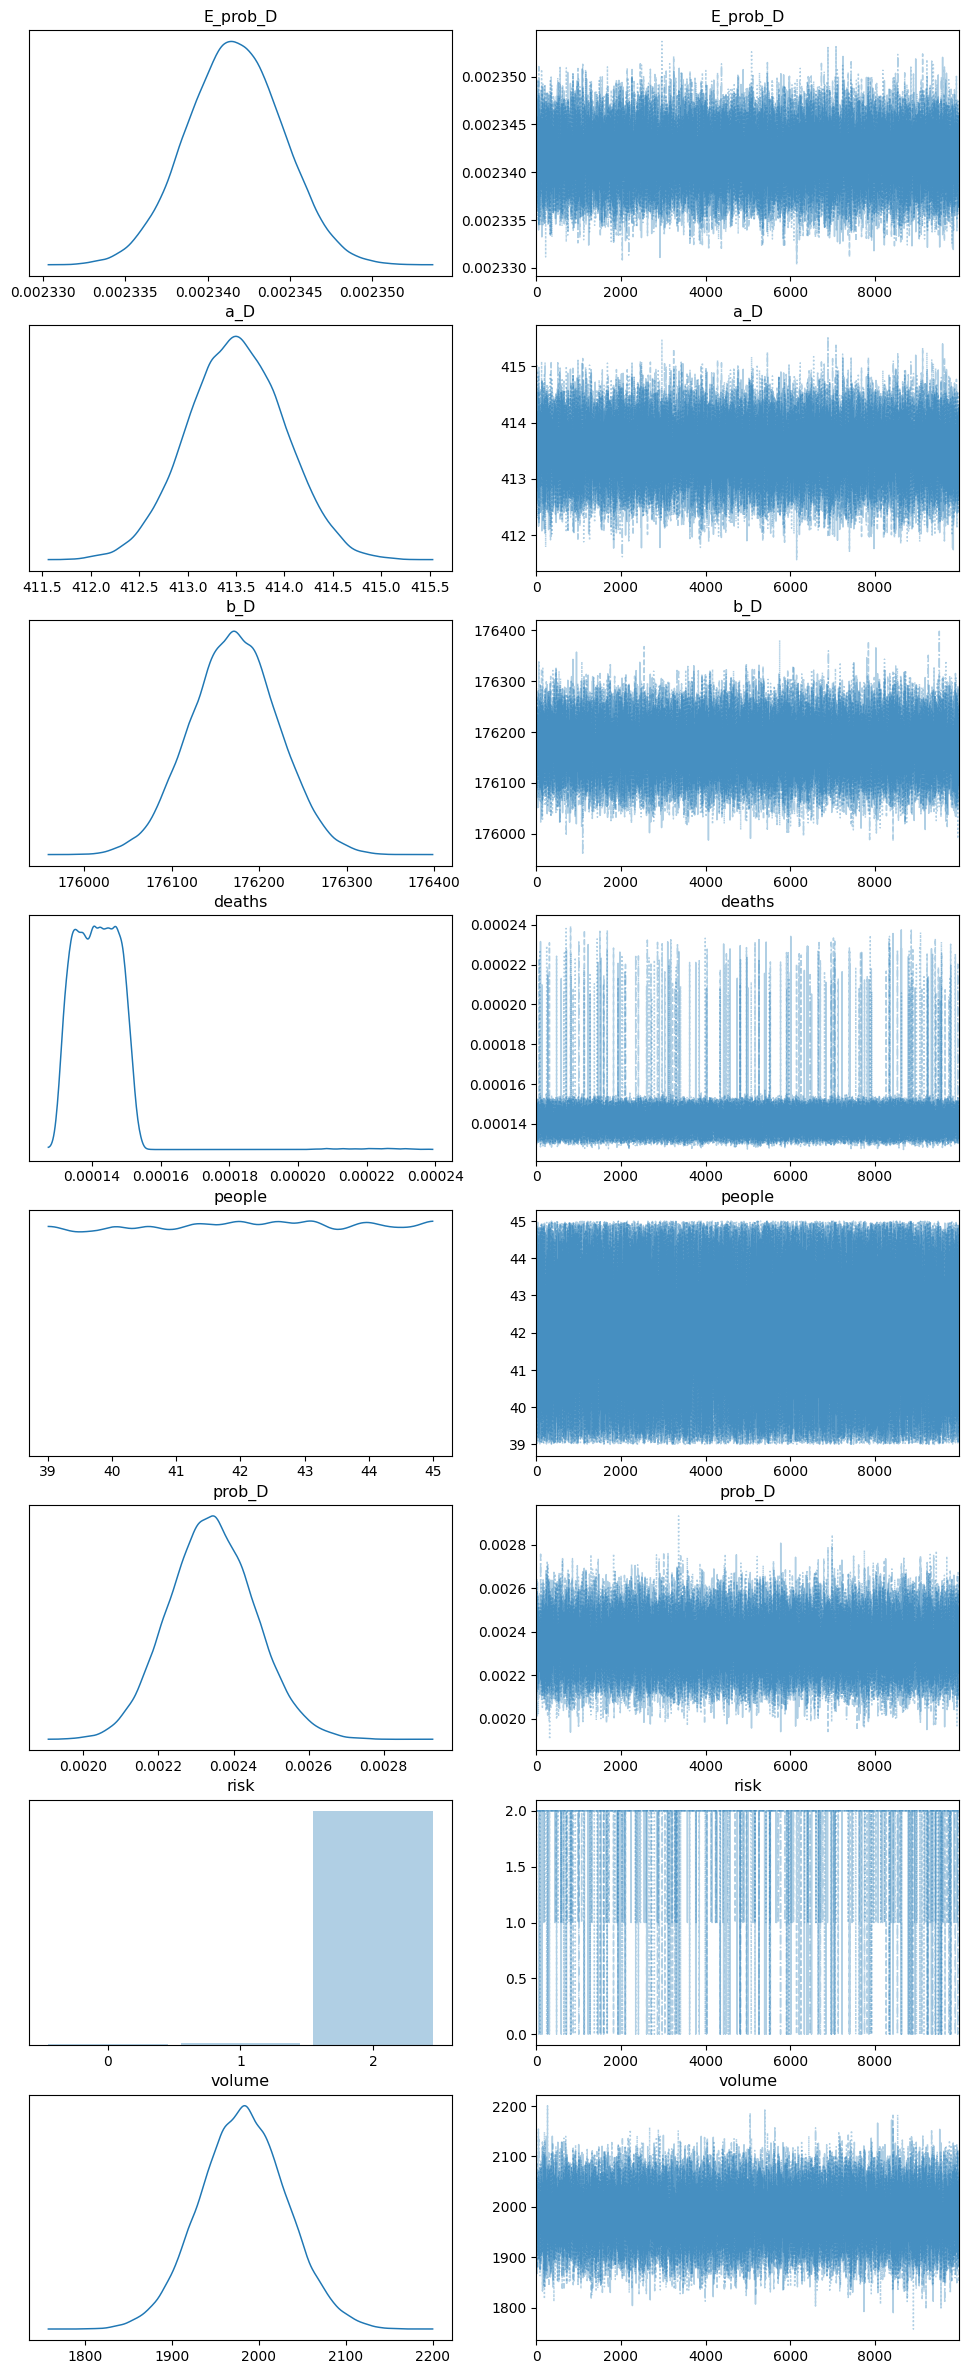

In [ ]:
#------------------------------
# Bayesian model using PyMC with Epistemic Uncertainties 
# Consider the probability of death as aleatory uncertainty
#------------------------------
# People and the probability of death are important factores affecting the uncertainty in expected deaths

# If view the probability of death as aleatory uncertainty
# The number of people will be the main driver of the epistemic uncertainty in the expected deaths

# If view the probability of death and the numebr of people as aleatory uncertainties
# The volume will be the main driver of the epistemic uncertainty in the expected deaths

start = time.perf_counter()

with pm.Model() as model:
    # Add uncertainties to the key inputs
    # For number of people, a uniform distribution around the observed value
    people = pm.Uniform("people", lower=max(0, idx_people - 3), upper=idx_people + 3)

    # For the probability of death, add uncertainties to the Beta distribution parameters (to show uncertainties on the model)
    a_D = pm.Normal("a_D", mu=413.5, sigma=0.5) 
    b_D = pm.Normal("b_D", mu=176171.5, sigma=50)
    prob_D = pm.Beta("prob_D", alpha=a_D, beta=b_D)
    E_prob_D = pm.Deterministic("E_prob_D", a_D / (a_D + b_D))
    
    # For Building volume, add a normal distribution around the observed value
    volume = pm.math.maximum(
        pm.Normal("volume", mu=idx_volume, sigma=50),
        200.0
    )

    # For activation risk, use transition matrix row corresponding to uncertainty in activation risk
    p_true = M[idx_risk]
    risk = pm.Categorical("risk", p=p_true)  # sample true risk
    
    # Get risk factors directly using switch
    alpha = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["alpha"],  # risk = 0
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["alpha"],  # risk = 1
            risk_factors["High Risk"]["alpha"]     # risk = 2
        )
    )
    
    beta = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["beta"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["beta"],
            risk_factors["High Risk"]["beta"]
        )
    )
    
    gamma = pm.math.switch(
        risk,
        risk_factors["Low Risk"]["gamma"],
        pm.math.switch(
            risk - 1,
            risk_factors["Middle Risk"]["gamma"],
            risk_factors["High Risk"]["gamma"]
        )
    )
    
    # Calculate fire probability using the selected risk factors
    prob_fire = 2/np.pi * pm.math.arctan(
        1.0 * pm.math.exp(alpha) * 
        volume ** beta / 
        pm.math.exp(21 * gamma)
    )

    deaths = pm.Deterministic("deaths", people*prob_fire*E_prob_D)
    
    trace = pm.sample(10000)  # runs MCMC automatically

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

pm.plot_posterior(trace, var_names=["deaths"])
az.plot_trace(trace, combined=True, figsize=(12, 30))
az.summary(trace)

## Some math calculations for verification

In [9]:
alpha = 413.5
beta = 176171.5
mean = alpha / (alpha + beta)
var = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1))
print(f"Mean Probability of Death: {mean:.8f}, Variance: {var:.10f}")

Mean Probability of Death: 0.00234165, Variance: 0.0000000132


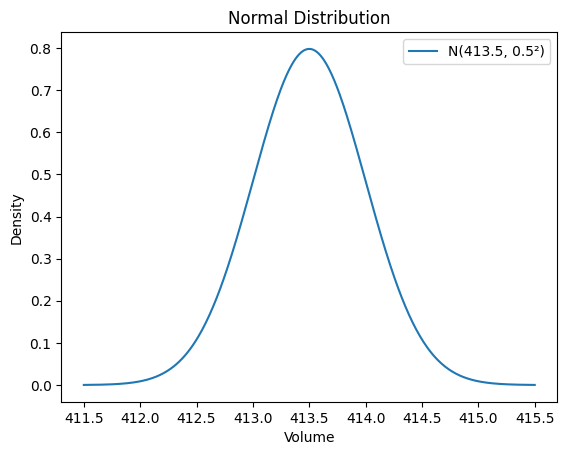

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mu = 413.5     # mean
sigma = 0.5   # standard deviation

# Generate x-values
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 500)

# Compute PDF
pdf = norm.pdf(x, mu, sigma)

# Plot
plt.plot(x, pdf, label=f"N({mu}, {sigma}²)")
plt.title("Normal Distribution")
plt.xlabel("Volume")
plt.ylabel("Density")
plt.legend()
plt.show()



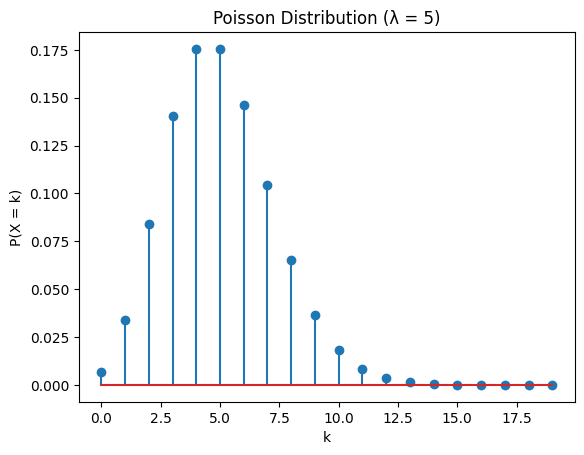

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Parameters
lam = 5  # λ = expected rate

# Support (integer values)
x = np.arange(0, 20)

# PMF (probability mass function)
pmf = poisson.pmf(x, lam)

# Plot
plt.stem(x, pmf)
plt.title(f"Poisson Distribution (λ = {lam})")
plt.xlabel("k")
plt.ylabel("P(X = k)")
plt.show()



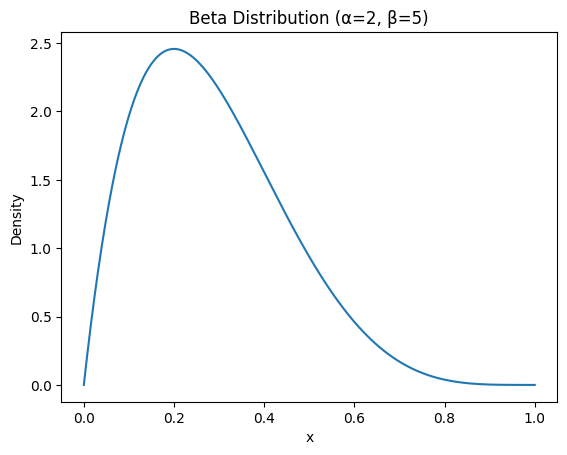

In [53]:
from scipy.stats import beta

a, b = 2, 5
x = np.linspace(0, 1, 500)
pdf = beta.pdf(x, a, b)

plt.plot(x, pdf)
plt.title(f"Beta Distribution (α={a}, β={b})")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()
